In [1]:
import pandas as pd
import numpy as np

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme()

**Load Data**

In [2]:
df = pd.read_parquet('data/wine/wine_review.parquet.gzip')
df['review_len'] = df.description.str.len()
print(df.shape)
df[['title', 'description', 'variety', 'points', 'country', 'taster_name', 'review_len']].head()

(100538, 16)


,title,description,variety,points,country,taster_name,review_len
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,87,Italy,Kerin O’Keefe,172
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,87,Portugal,Roger Voss,227
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,87,US,Paul Gregutt,186
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,87,US,Alexander Peartree,199
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,87,US,Paul Gregutt,249


**Load Embeddings**

**Split Training and Test Data**

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X, y = df.drop(['points', 'description', 'price', 'title', 'winery', 'taster_name', 'band', 'quality', 'wine_style',	'type',	'classification'], axis=1), df.points
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,country,variety,year,location,review_len
71166,Italy,Sangiovese,2004,Tuscany,270
80735,US,Red Blend,2009,Washington,284
25052,France,Sauvignon Blanc,2016,Côtes de Gascogne,194
116451,US,Bordeaux-style Red Blend,2006,Colorado,231
14434,US,Pinot Noir,2013,California,176


**Create Pipeline**

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression

def create_review_len_pipeline(estimator = LinearRegression()):
  return Pipeline([('pre',ColumnTransformer([('num', StandardScaler(), ['year']),
                                             ('len', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scale', StandardScaler())]),['review_len']),
                                             ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'variety', 'location'])
                                           ])),
                    ('lr',estimator)
                  ])

In [5]:
lr_pipe = create_review_len_pipeline(LogisticRegression(max_iter=500)).fit(X_train, y_train)
lr_pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('len',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['review_len']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'variety',
                                                   'location'])])),
                ('lr', LogisticRegression(max_iter=500))])

**Helper to Create Confusion Matrix**

In [6]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def validation_metrics(best_estimator, X_val, y_val):
  """
  function return summary of evaluation for the model 
  """
  y_preds = best_estimator.predict(X_val)
  y_preds_proba = best_estimator.predict_proba(X_val)

  # change evaluation methods if needed
  average = 'macro'
  accuracy = accuracy_score(y_val, y_preds)
  f1 = f1_score(y_val, y_preds, average=average)
  hammer_loss= hamming_loss(y_val, y_preds)
  precision = precision_score(y_val, y_preds, average=average)
  recall = recall_score(y_val, y_preds, average=average)
  roc_auc = roc_auc_score(y_val, y_preds_proba, average='weighted',multi_class='ovr')
  class_report = classification_report(y_val, y_preds)

  df = pd.DataFrame({'accuracy': accuracy,
                     'f1': f1,
                     'hammer_loss': hammer_loss,
                     'precision': precision,
                     'recall': recall,
                     'roc_auc': roc_auc}, 
                    index=[best_estimator.__class__.__name__])
  
  return {
      'detail': df,
      'summary': class_report,
      'predictions': y_preds,
      'pred_proba': y_preds_proba
  }

def plot_conf_matrix(y_true, y_pred):
  """
  Plot confusion matrix
  """
  _, ax = plt.subplots(figsize=(15, 10))
  conf_matrix = confusion_matrix(y_true, y_pred, normalize='pred', labels=np.unique(df.points))
  sns.set(font_scale=1)
  sns.heatmap(conf_matrix, 
              xticklabels=np.unique(df.points), yticklabels=np.unique(df.points),
              annot=True, 
              ax=ax, 
              cmap="Purples", 
              fmt=".2f", 
              annot_kws={"size": 10});
  ax.set_xlabel('Predictions')
  ax.set_ylabel('True lables')

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


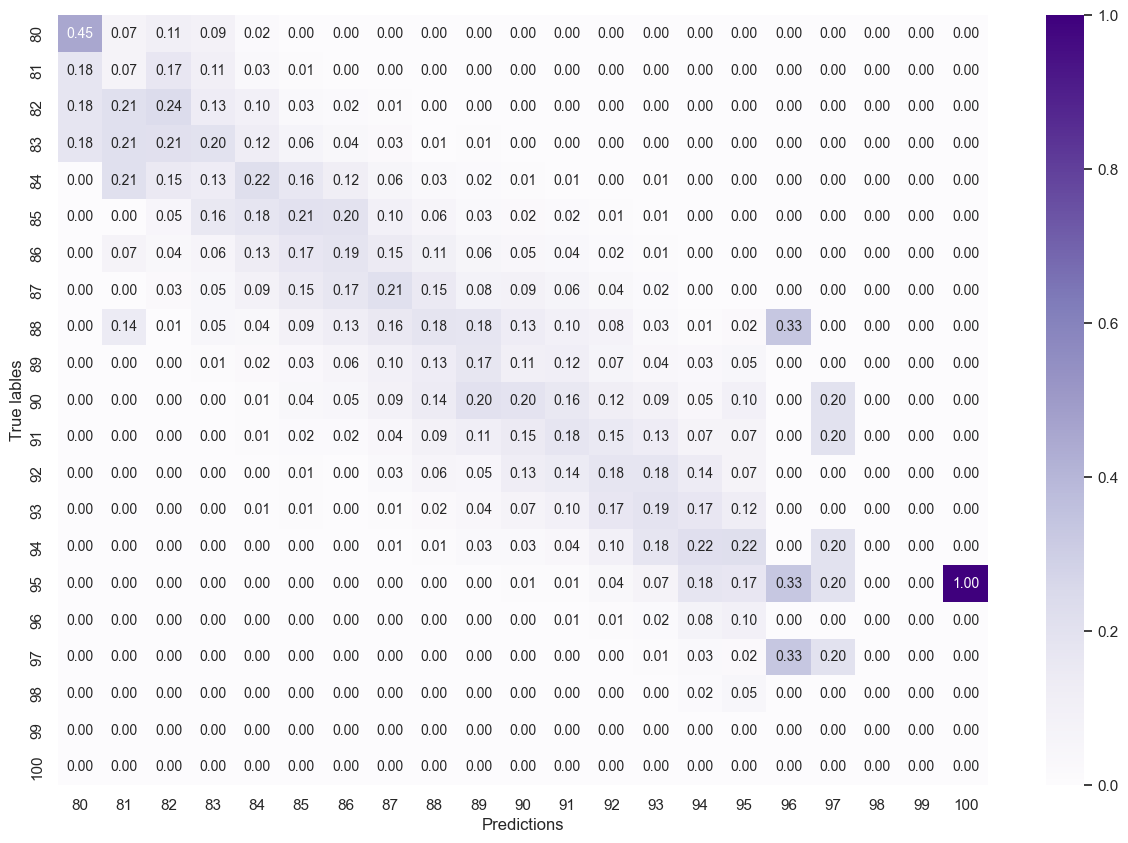

In [7]:
plot_conf_matrix(y_test, lr_pipe.predict(X_test))

In [8]:
cols = ['year', 'variety', 'country', 'location']

In [9]:
tfidf = pd.read_parquet('data/wine/wine_review-tfidf.parquet.gzip').drop(['year', 'variety'], axis=1)
print(tfidf.shape)
X, y = pd.concat([df[cols], tfidf], axis=1), df.points
X.head()

(100538, 940)


,year,variety,country,location,accent,accessible,accompany,acid,acidic,acidity,...,worth,wrap,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
0,2013,White Blend,Italy,Etna,0.0,0.0,0.0,0.0,0.0,0.136429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011,Portuguese Red,Portugal,Douro,0.0,0.0,0.0,0.0,0.0,0.154443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,Pinot Gris,US,Oregon,0.0,0.0,0.0,0.0,0.0,0.128762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013,Riesling,US,Michigan,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012,Pinot Noir,US,Oregon,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def create_token_pipeline(estimator = LinearRegression()):
  return Pipeline([('pre',ColumnTransformer([('num', StandardScaler(), ['year']),
                                             ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'variety', 'location'])
                                           ], remainder='passthrough')),
                    ('lr',estimator)
                  ])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,year,variety,country,location,accent,accessible,accompany,acid,acidic,acidity,...,worth,wrap,yeast,yeasty,yellow,yield,young,youthful,zest,zesty
71166,2004,Sangiovese,Italy,Tuscany,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
80735,2009,Red Blend,US,Washington,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25052,2016,Sauvignon Blanc,France,Côtes de Gascogne,0.0,0.0,0.0,0.0,0.0,0.170615,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
116451,2006,Bordeaux-style Red Blend,US,Colorado,0.0,0.0,0.0,0.0,0.0,0.130914,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14434,2013,Pinot Noir,US,California,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.273009,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
lr_pipe = create_token_pipeline(LogisticRegression(max_iter=500)).fit(X_train, y_train)
lr_pipe

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'variety',
                                                   'location'])])),
                ('lr', LogisticRegression(max_iter=500))])

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


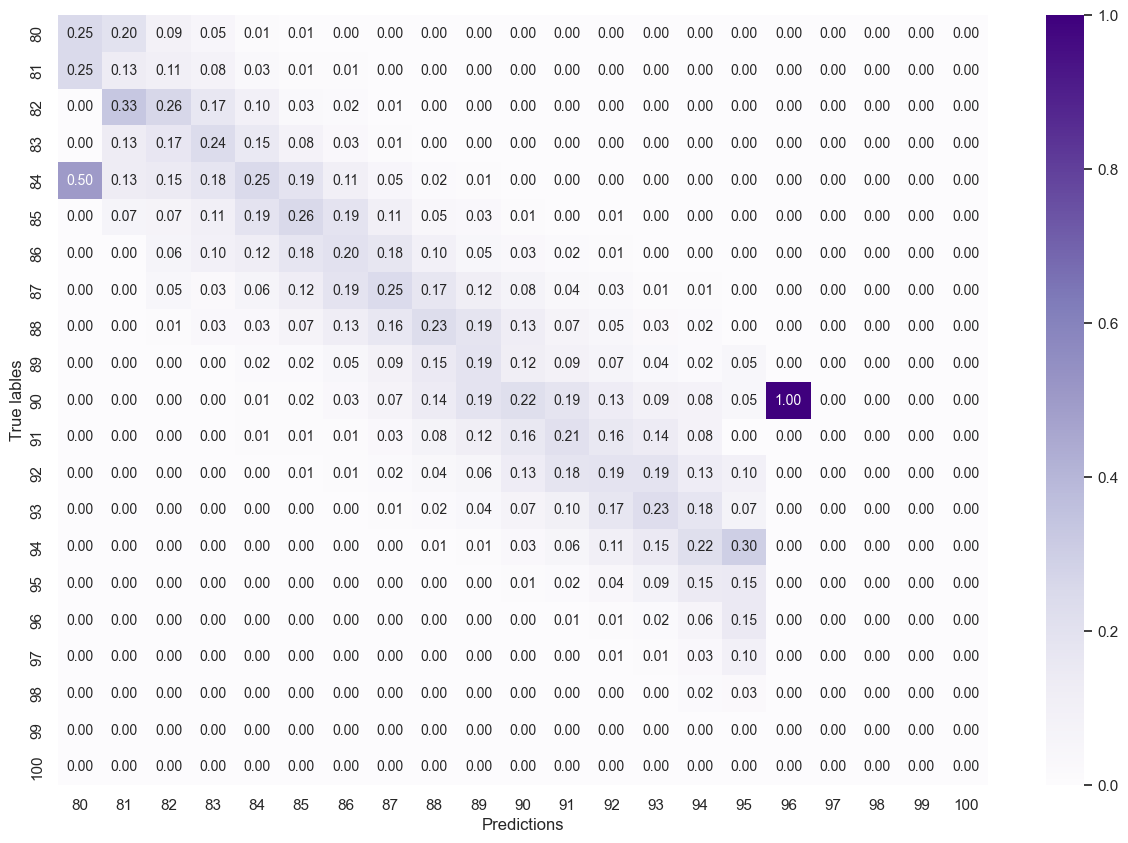

In [13]:
plot_conf_matrix(y_test, lr_pipe.predict(X_test))

In [14]:
mpnet = pd.read_parquet('data/wine/mpnet_embeddings.parquet.gzip')
mpnet.columns = mpnet.columns.astype(str)
print(mpnet.shape)
X, y = pd.concat([df[cols], mpnet], axis=1), df.points
X.head()

(100538, 768)


,year,variety,country,location,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,2013,White Blend,Italy,Etna,0.036825,0.040504,-0.049127,0.012060,-0.017809,0.045190,...,-0.018225,-0.022451,-0.030674,0.030395,-0.036411,0.075180,-0.021670,0.017032,-0.024503,-0.021728
1,2011,Portuguese Red,Portugal,Douro,0.015400,0.076190,-0.017931,0.004965,-0.076234,0.021419,...,-0.071278,0.033845,-0.002066,0.018129,-0.004691,0.028105,-0.042770,0.010317,0.063025,-0.026926
2,2013,Pinot Gris,US,Oregon,0.032447,0.012291,-0.034564,-0.020621,-0.048290,0.031377,...,-0.126703,0.035472,0.029064,0.006745,-0.012355,0.030802,-0.012589,0.024286,0.023172,-0.017200
3,2013,Riesling,US,Michigan,0.076041,0.044183,-0.017158,-0.041186,-0.030582,0.051051,...,-0.063876,-0.010313,0.004829,0.009389,-0.011263,0.035524,-0.014419,0.030267,-0.036529,-0.043187
4,2012,Pinot Noir,US,Oregon,0.011352,0.057223,-0.023293,0.022438,-0.078027,0.046609,...,-0.058865,0.031108,0.006709,0.020604,-0.017218,0.023554,-0.039825,0.021364,0.025454,-0.022300


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,year,variety,country,location,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
71166,2004,Sangiovese,Italy,Tuscany,-0.015517,-0.028565,-0.026781,0.053700,-0.004936,0.020011,...,-0.097514,-0.021607,0.013403,0.001048,-0.045254,0.019765,-0.018652,-0.001024,0.030262,0.033093
80735,2009,Red Blend,US,Washington,0.040970,-0.026239,-0.024915,-0.005610,-0.063496,-0.009150,...,-0.023481,0.030308,-0.017740,0.000611,0.005001,0.068376,-0.066297,0.019780,0.000633,-0.031555
25052,2016,Sauvignon Blanc,France,Côtes de Gascogne,0.068519,-0.005688,0.005931,0.014898,-0.036191,0.010095,...,-0.052174,-0.017084,0.017666,0.028166,-0.028412,0.006846,-0.051830,0.015403,0.043663,-0.062009
116451,2006,Bordeaux-style Red Blend,US,Colorado,0.045580,0.001349,-0.016296,0.006883,-0.051746,0.011897,...,-0.059892,0.024183,-0.005966,0.022143,-0.005425,0.006573,-0.025165,-0.003998,0.006135,-0.016485
14434,2013,Pinot Noir,US,California,0.013345,0.010441,-0.007903,0.004010,-0.054116,0.021753,...,-0.026164,-0.007857,-0.013207,0.018279,0.022725,0.030198,-0.043576,0.027668,-0.036869,0.010956


In [16]:
lr_pipe = create_token_pipeline(LogisticRegression(max_iter=500)).fit(X_train, y_train)
lr_pipe

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['country', 'variety',
                                                   'location'])])),
                ('lr', LogisticRegression(max_iter=500))])

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


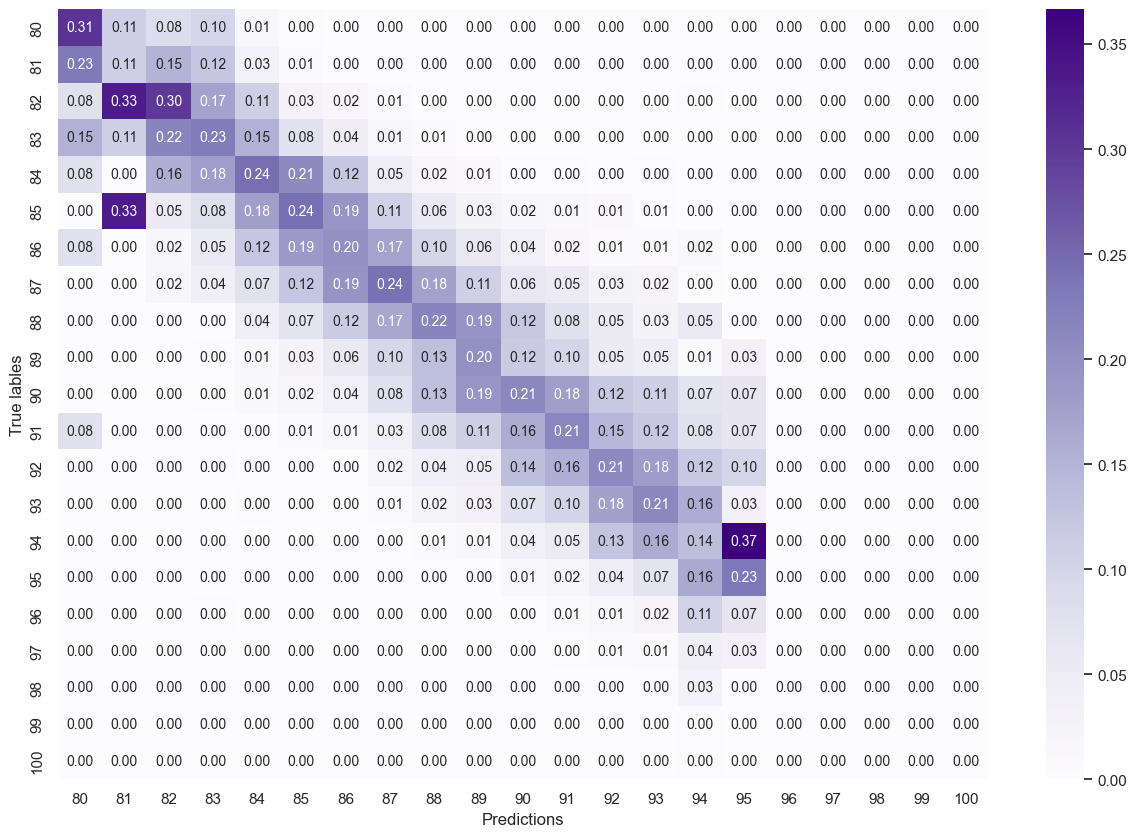

In [17]:
plot_conf_matrix(y_test, lr_pipe.predict(X_test))